# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dany's Directory
%cd /content/drive/My Drive/Colab Notebooks/imagenet/

In [ ]:
# Christopher's directory
%cd /content/drive/My Drive/imagenet/

/content/drive/.shortcut-targets-by-id/1cZ-V95iJX2lZXKQeHjcbONaKRVlwKagP/imagenet


# Import Libraries


In [ ]:
import os
import cv2
import shutil
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow --q

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

#  Moving the Data


In [ ]:
# Sample images and move them to the proper directories
random.seed(42)
src_path = os.getcwd()

# Inspecting the Data

In [ ]:
training_path = os.getcwd() + '/preliminary_model_testing_data/train'
validation_path = os.getcwd() + '/preliminary_model_testing_data/validation'
testing_path = os.getcwd() + '/preliminary_model_testing_data/test'

In [ ]:
# Create Image Data Generator instance
data_generator = ImageDataGenerator() # rescale=1.0/255.0, featurewise_center=True, horizontal_flip=True, brightness_range=[0.7,1.3], zoom_range=[0.7, 1.3], shear_range = 0.2,

# Create training iterator, validation iterator & testing iterator
train_it = data_generator.flow_from_directory(training_path,
                                              class_mode="binary",
                                              batch_size=32,
                                              target_size = (224, 224))

validation_it = data_generator.flow_from_directory(validation_path,
                                                   class_mode="binary",
                                                   batch_size=16,
                                                   target_size = (224, 224))

test_it = data_generator.flow_from_directory(testing_path,
                                             class_mode="binary",
                                             batch_size=16,
                                             target_size = (224, 224),)

batchX, batchY = train_it.next()
print("BatchX shape: {}, min: {}, max: {}".format(batchX.shape, batchX.min(), batchX.max()))
print("BatchY shape: {}".format(batchY.shape))

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
BatchX shape: (32, 224, 224, 3), min: 0.0, max: 255.0
BatchY shape: (32,)


# ResNet 152


In [ ]:
# Re-size all the images to this
IMAGE_SIZE = [224, 224] # The ResNet50 model was originally trained on images of this size from the ImageNet dataset.

In [ ]:
resnet = ResNet152(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) # include_top=False indicates that the final classification layer of the original ResNet50 model should not be included because the original ResNet50 model was trained to classify images into 1000 different classes from the ImageNet dataset. So, we need to add our own custom classification layer(s) later.

234698864/234698864 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet.layers:
    layer.trainable = False # freeze the weights of all layers in the ResNet50 base model, making them non-trainable during the training process.

In [ ]:
x = Flatten()(resnet.output)
# Most neural network architectures, including ResNet50, use convolutional and pooling layers to extract spatial features from the input images. The output of these layers is typically a multi-dimensional tensor (e.g., (batch_size, height, width, channels)). However, dense layers expect a one-dimensional vector as input.
# The purpose of flattening the output tensor is to prepare it for the following dense (fully connected) layers that we will add for our binary classification task.

In [ ]:
prediction = Dense(1, activation='sigmoid')(x) # creating a dense (fully connected) layer as the final output layer for our classification task.

In [ ]:
# Create Model
# model = Model(inputs=resnet.input, outputs=prediction) # creating the final model architecture by combining the ResNet50 base model with the new classification layer we added
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
# Compile Model
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Callbacks
callbacks = [
    ModelCheckpoint("Models/PreliminaryTesting/ResNet152_no_rescaling_model.h5", save_weights_only=True, save_freq=5)
]

# Fit the model with early stopping callback
history = model.fit_generator(
  train_it,
  validation_data=validation_it,
  epochs=20,
  steps_per_epoch=10,
  validation_steps=5,
  verbose=1,
  callbacks=callbacks
)

<ipython-input-16-3e6f2fd3a194>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
10/10 [==============================] - 324s 28s/step - loss: 2.9103 - accuracy: 0.5469 - val_loss: 3.6716 - val_accuracy: 0.6625
Epoch 2/20
10/10 [==============================] - 273s 28s/step - loss: 3.3979 - accuracy: 0.6562 - val_loss: 3.3373 - val_accuracy: 0.6875
Epoch 3/20
10/10 [==============================] - 257s 26s/step - loss: 2.3554 - accuracy: 0.7219 - val_loss: 2.8608 - val_accuracy: 0.7000
Epoch 4/20
10/10 [==============================] - 227s 23s/step - loss: 2.4648 - accuracy: 0.7344 - val_loss: 2.9994 - val_accuracy: 0.6750
Epoch 5/20
10/10 [==============================] - 257s 26s/step - loss: 2.1549 - accuracy: 0.7563 - val_loss: 2.8183 - val_accuracy: 0.6875
Epoch 6/20
10/10 [==============================] - 220s 22s/step - loss: 1.6740 - accuracy: 0.7781 - val_loss: 1.0778 - val_accuracy: 0.8000
Epoch 7/20
10/10 [==============================] - 258s 26s/step - loss: 1.8201 - accuracy: 0.8031 - val_loss: 2.1990 - val_accuracy: 0.7500
Epoch 

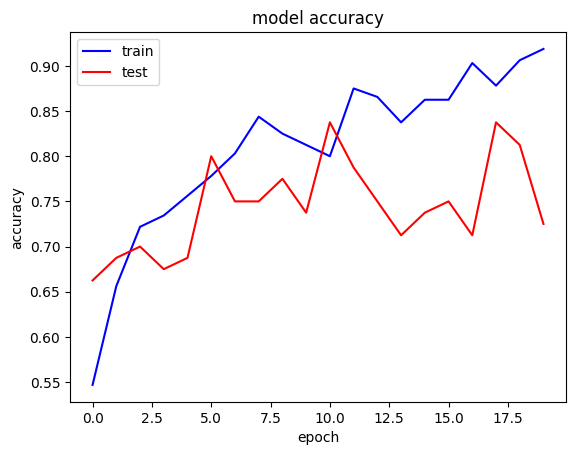

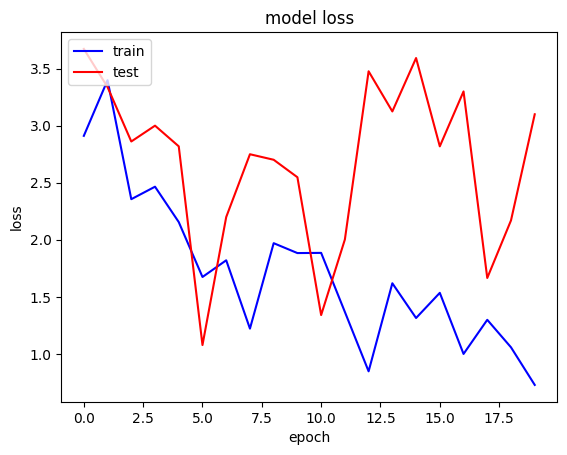

In [17]:
# Plot the model's training and validation accuracy
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the model's training and validation loss
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Testing


In [18]:
model.evaluate(test_it, batch_size=5)

25/25 [==============================] - 200s 8s/step - loss: 6.1670 - accuracy: 0.6125


[6.166950702667236, 0.612500011920929]

In [ ]:
y_pred = model.predict(test_it, batch_size=5)

In [ ]:
from sklearn.metrics import confusion_matrix

test_Y = test_it.labels
conf_matrix = confusion_matrix(test_Y, y_pred)

print("Confusion Matrix: ")
print(conf_matrix)